<a href="https://colab.research.google.com/github/adupatil/Hindi-to-English-Translator/blob/main/nlp_summarizer_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
import nltk
from nltk.tokenize import word_tokenize
import seaborn as sns
from time import time
import matplotlib.pyplot as plt
import torch
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#train = pd.read_csv("/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv").drop(columns="id")
test = pd.read_csv("/content/drive/MyDrive/NLP_Project/datasets/cnn_dailymail/test.csv").drop(columns="id")
validation = pd.read_csv("/content/drive/MyDrive/NLP_Project/datasets/cnn_dailymail/validation.csv").drop(columns="id")

---
## EDA 
---

In [ ]:
train.head()

,article,highlights
0,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [ ]:
train.describe()

,article,highlights
count,287113,287113
unique,284005,282197
top,(CNN) -- Dubai could lose its place on the Wom...,This page includes the show Transcript and the...
freq,3,83


In [ ]:
train['article'][0]

"By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained 

In [ ]:
train['highlights'][0]

'Bishop John Folda, of North Dakota, is taking time off after being diagnosed .\nHe contracted the infection through contaminated food in Italy .\nChurch members in Fargo, Grand Forks and Jamestown could have been exposed .'

In [ ]:
train['article_length'] = train['article'].apply(lambda x : len(x.split()))
train['highlights_length'] = train['highlights'].apply(lambda x : len(x.split()))

<AxesSubplot:xlabel='article_length', ylabel='Count'>

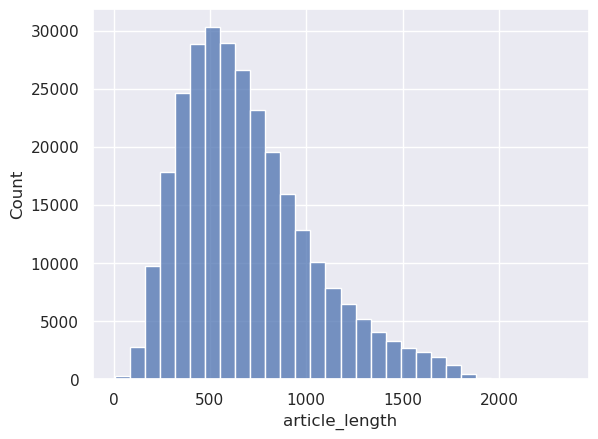

In [ ]:
sns.set_theme('notebook')
sns.histplot(data=train,x='article_length',bins=30)

We can observe the following:
1. There are some article with length 0
2. Most articles range between 450 - 900 words

<AxesSubplot:xlabel='highlights_length', ylabel='Count'>

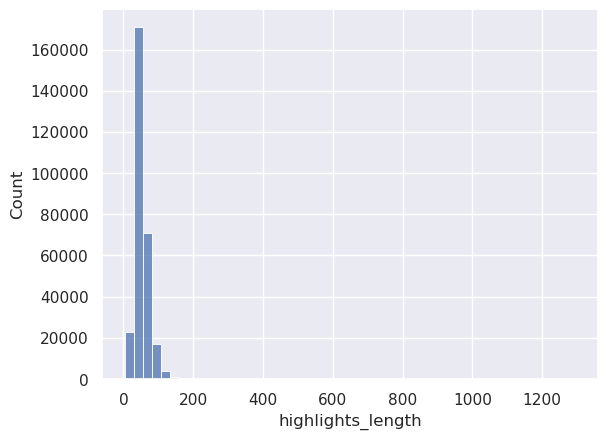

In [ ]:
sns.histplot(data=train,x='highlights_length',bins=50)

We observe the following:
1. There are some outlier(s) in highlights which will affect our model performance

<AxesSubplot:xlabel='article_length'>

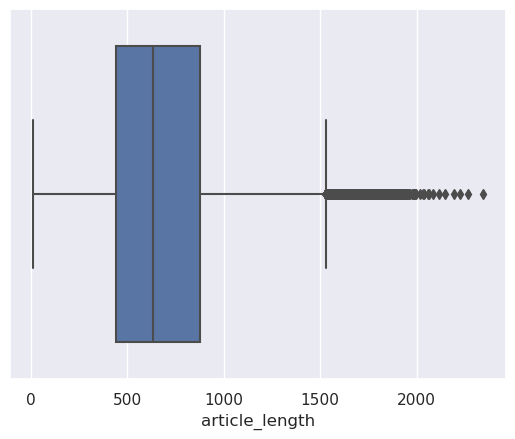

In [ ]:
sns.boxplot(data=train,x='article_length')

<AxesSubplot:xlabel='highlights_length'>

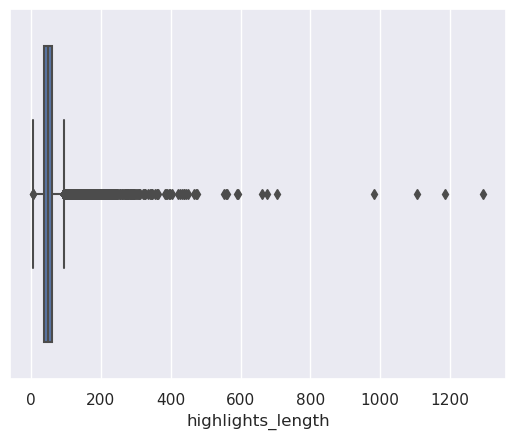

In [ ]:
sns.boxplot(data=train,x='highlights_length')

We can observe the average length of highlights varies a lot, so we will have to , decide some range and prune the other values

In [ ]:
## check for null
train.isnull().sum()

article              0
highlights           0
article_length       0
highlights_length    0
dtype: int64

In [ ]:
## Checking for duplicates
train.duplicated(subset= ['article', 'highlights']).sum()

3098

In [ ]:
train = train.drop_duplicates(subset=['article', 'highlights'])

---
## Remove Outliers
---

In [ ]:
print(f"{len(train[(train['article_length']>200) & (train['article_length']<1300)])/len(train)*100}% of the artciles lie between 200 and 1300 words")

91.35925919405665% of the artciles lie between 200 and 1300 words


In [ ]:
# We will drop the outliers
train = train[(train['article_length']>200) & (train['article_length']<1300)]

<AxesSubplot:xlabel='article_length'>

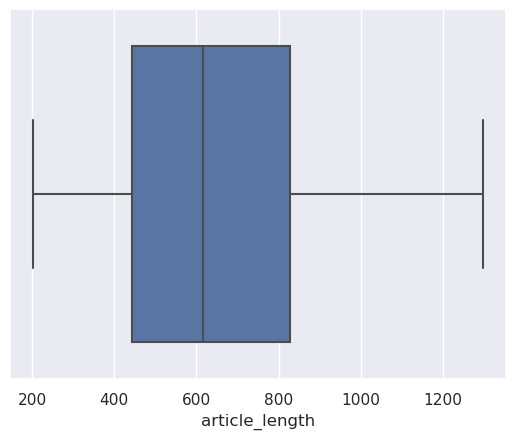

In [ ]:
sns.boxplot(data=train,x='article_length')

Outliers have been removed from articles

In [ ]:
print(f"{len(train[(train['highlights_length']>20) & (train['highlights_length']<200)])/len(train)*100}% of the highights lie between 30 and 200 words")

97.87146303675898% of the highights lie between 30 and 200 words


In [ ]:
## Removing the outliers in highlights
train = train[(train['highlights_length']>20) & (train['highlights_length']<200)]

<AxesSubplot:xlabel='highlights_length'>

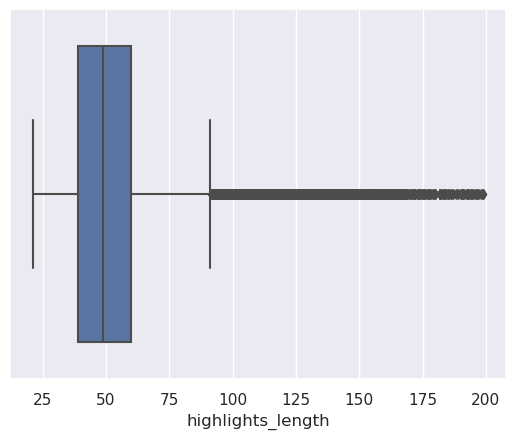

In [ ]:
sns.boxplot(data=train,x='highlights_length')

---
## Text Preprocessing
---

In [ ]:
from gensim.parsing import strip_tags, strip_numeric, strip_multiple_whitespaces, stem_text, strip_punctuation, remove_stopwords
from gensim.parsing import preprocess_string
from gensim import parsing
import re
from time import time

In [ ]:
remove_emails = lambda s: re.sub(r'\S+@\S+', '', s)
remove_single_char = lambda s: re.sub(r'\s+\w{1}\s+', '', s)

CLEAN_FILTERS = [
                remove_emails,
                strip_tags,
                strip_numeric, 
                strip_multiple_whitespaces]

def clean(document):
    processed_words = preprocess_string(document, CLEAN_FILTERS)
    
    return processed_words

def joinList(processed_words):
    return ' '.join(processed_words)

In [ ]:
## Considering 30% of the total dataset ~ 60k rows
train_df = train.sample(frac=0.3)

In [ ]:
## Cleaning articles
t0 = time()
train_df['cleaned_articles'] = train_df['article'].apply(clean).apply(joinList)
validation['cleaned_articles'] = validation['article'].apply(clean).apply(joinList)
print(f"done in {time()-t0}")

done in 16.583983898162842


In [ ]:
## Cleaning highlights
t0 = time()
train_df['highlights'] = train_df['highlights'].apply(lambda x : strip_tags(x))
validation['highlights'] = validation['highlights'].apply(lambda x : strip_tags(x))
print(f"done in {time()-t0}")

done in 0.034847259521484375


In [ ]:
train_df['cleaned_articles'].iloc[0]

"Juan Cuadrado had come to symbolise a young man with ambition and desire to succeed against the odds long before his £million transfer to Chelsea. Cuadrado was born in , days before Chelsea were relegated from the top flight, and raised in the port city of Tumaco, in Colombia's south west, which became one of the most dangerous and violent regions of the country as the drug wars forced the coca growers out of more traditional areas. His father Guillermo, who drove a fuel tanker, was shot dead by guerrillas when Juan was five-years-old. In interviews, he said he remembered little about the incident and hid under the bed. Juan Cuadrado joined Chelsea from Fiorentina in a £million deal on transfer deadline day . The Colombian midfielder moved to Europe with Serie A side Udinese before joining Fiorentina . He was raised by his mother Marcela and they remain inseparable. She has promised to stay with him until he has a family of his own. Marcela and Juan's half-sister Maria Angel moved to 

In [ ]:
train_df['highlights'].iloc[0]

"Juan Cuadrado signed for Chelsea from Fiorentina in a £27m deal .\nThe footballer's father was murdered when he was five-years-old .\nCuadrado's mother moves from country to country with him .\nHe has played in Colombia, Italy and Argentina .\nAs a boy, Cuadrado idolised Brazilian striker Ronaldo ."

---
## Data Preprocessing
---

In [ ]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.7 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "facebook/bart-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
## Setting the max_length for padding or truncating articles and summaries
max_length_art = 1000
max_length_sum = 180

In [ ]:
def preprocess_data(data):
    model_inputs = []
    labels = []
    for i in range(len(data)):
      model_inputs.append(tokenizer(
      data[i:i+1]["cleaned_articles"].tolist(),
      max_length=max_length_art,
      truncation=True,
    ))
      labels.append(tokenizer(
      data[i:i+1]["highlights"].tolist(), max_length=max_length_sum, truncation=True
    )['input_ids'])
    return model_inputs,labels

def create_tokenized_data(data):
    model_inputs,labels = preprocess_data(data)
    for item,label in zip(model_inputs,labels):
        item.update({"labels":label})
    return model_inputs

In [ ]:
t0=time()
tokenized_train = create_tokenized_data(train_df)
tokenized_val = create_tokenized_data(validation)
print(f"Completed in {time()-t0} secs")

Completed in 284.07619762420654 secs


In [ ]:
tokenized_data_train = pd.DataFrame()
tokenized_data_val = pd.DataFrame()

In [ ]:
tokenized_data_train['train'] = tokenized_train
tokenized_data_val['val'] = tokenized_val

In [ ]:
tokenized_data_train.head()

,train
0,"[input_ids, attention_mask, labels]"
1,"[input_ids, attention_mask, labels]"
2,"[input_ids, attention_mask, labels]"
3,"[input_ids, attention_mask, labels]"
4,"[input_ids, attention_mask, labels]"


In [ ]:
tokenized_data_train.to_csv("./tokenized_data_train.csv",index=False)
tokenized_data_val.to_csv("./tokenized_data_val.csv",index=False)

---
## Model training
---

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
tokenized_data_train = pd.read_csv("/content/drive/MyDrive/NLP_Project/datasets/tokenized_data_train.csv",nrows=10000)
tokenized_data_val = pd.read_csv("/content/drive/MyDrive/NLP_Project/datasets/tokenized_data_val.csv",nrows=1000)

In [ ]:
tokenized_data_train.iloc[1].values

array(["{'input_ids': [0, 133, 78, 9, 292, 11544, 13, 8972, 5227, 42, 526, 9, 5, 8755, 1239, 317, 11, 5524, 42, 186, 6, 147, 5, 2772, 9, 5, 111, 958, 5454, 2234, 1639, 10, 4884, 219, 2849, 12, 40776, 7, 5, 213, 1033, 12, 261, 159, 5, 921, 23, 5, 1582, 2616, 4, 152, 40, 28, 5227, 17, 27, 29, 78, 2018, 11, 10, 1675, 221, 4164, 3637, 515, 187, 94, 550, 6, 8, 78, 1967, 4558, 187, 37, 1550, 2660, 94, 11, 5, 111, 397, 12259, 17166, 1967, 37, 4457, 11, 1261, 11, 719, 4, 407, 4309, 5, 1716, 13495, 14, 6246, 6337, 94, 186, 4, 1398, 32, 292, 1142, 5227, 531, 1948, 148, 209, 292, 1061, 114, 37, 965, 17, 27, 90, 7, 213, 1716, 23, 17538, 4, 3759, 13665, 12, 958, 5454, 1924, 8972, 5227, 2653, 1227, 7, 386, 39, 191, 30, 816, 80, 1061, 11, 10, 3236, 479, 286, 5227, 7, 339, 277, 5454, 37, 531, 1100, 114, 37, 16, 2564, 615, 7, 1539, 5, 3829, 9, 16498, 1509, 13693, 6506, 479, 4557, 7, 961, 54, 13892, 49, 4312, 15, 84, 637, 7, 489, 697, 1953, 9, 20, 2117, 15, 481, 12, 560, 12, 2456, 2384, 4, 440, 65, 802,

In [ ]:
## Using eval to convert the dictionaries saved as str in dataframe to type dict
tokenized_data_train['train'] = tokenized_data_train['train'].apply(lambda x : eval(x))
tokenized_data_val['val'] = tokenized_data_val['val'].apply(lambda x : eval(x))

In [ ]:
def convert_list(x):
    col = {}
    col['input_ids'] = x['input_ids'][0]
    col['attention_mask'] = x['attention_mask'][0]
    col['labels'] = x['labels'][0]
    return col

In [ ]:
# converting from list(list) to a single list
tokenized_data_train['train'] = tokenized_data_train['train'].apply(lambda x : convert_list(x) )
tokenized_data_val['val'] = tokenized_data_val['val'].apply(lambda x : convert_list(x))

In [ ]:
## Saving dataset
tokenized_data_train.to_csv("/content/drive/MyDrive/NLP_Project/datasets/tokenized_data_train.csv",index=False)
tokenized_data_val.to_csv("/content/drive/MyDrive/NLP_Project/datasets/tokenized_data_val.csv",index=False)

In [ ]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import Seq2SeqTrainingArguments

batch_size = 8
num_train_epochs = 3
# Show the training loss with every epoch
logging_steps = len(tokenized_data_train["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

args = Seq2SeqTrainingArguments(
    output_dir=f"./content/drive/MyDrive/NLP_Project/model/{model_name}-finetuned-cnn-summarizer.pt",
    evaluation_strategy="epoch",
    learning_rate=5.6e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
    push_to_hub=False,
)

## Evaluation Metric

In [ ]:
! pip install evaluate
! pip install rouge_score

In [ ]:
import evaluate

rouge_score = evaluate.load("rouge")

In [ ]:
generated_summary = "I absolutely loved reading the Hunger Games"
reference_summary = "I loved reading the Hunger Games"

In [ ]:
scores = rouge_score.compute(
    predictions=[generated_summary], references=[reference_summary]
)
scores

{'rouge1': 0.923076923076923,
 'rouge2': 0.7272727272727272,
 'rougeL': 0.923076923076923,
 'rougeLsum': 0.923076923076923}

In [ ]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    # Compute ROUGE scores
    result = rouge_score.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract the median scores
    #result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    return {k: round(v, 4) for k, v in result.items()}

---
## Data Collation
---

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
features = [tokenized_data_train["train"][i] for i in range(2)]
data_collator(features)

You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_ids': tensor([[   0,  863, 7372,  ...,    1,    1,    1],
        [   0,  133,   78,  ...,   93,  745,    2]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'labels': tensor([[    0,   863,  7372, 10016, 27968,  2102,  1419,    13,  3098,    31,
         19643,  1688,  3999,  1243,    11,    10,   984,  2518,   119,   432,
           479, 50118,   133, 19931,    18,  1150,    21,  9694,    77,    37,
            21,   292,    12, 12857,    12,   279,   479, 50118, 37454, 27968,
          2102,    18,   985,  3136,    31,   247,     7,   247,    19,   123,
           479, 50118,   894,    34,   702,    11,  8700,     6,  2627,     8,
          5244,   479, 50118,  1620,    10,  2143,     6, 10016, 27968,  2102,
         23390,  1720,  6606,  5955,  7991,   479,     2],
        [    0,   565, 10168,  5227,    16,   278,     7,   310,    39,    78,
          1675,   221,  4164,  3637,   515,   187,    94,   550,   479, 50118,
           1

---
## Creating Trainer
---

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_data_train["train"],
    eval_dataset=tokenized_data_val["val"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
t0= time()
trainer.train()
print(f"Training done in{time()-t0}")

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,1.890000,1.861508,0.231200,0.107600,0.190900,0.218500
2,1.613700,1.870957,0.233400,0.108300,0.190500,0.219200
3,1.425700,1.891384,0.232400,0.107000,0.190400,0.218400


Training done in5020.020175218582


In [ ]:
torch.save(model,"/content/drive/MyDrive/NLP_Project/model/cnn_summarizer.pt")

In [ ]:
trainer.evaluate()

{'eval_loss': 1.8913843631744385,
 'eval_rouge1': 0.2324,
 'eval_rouge2': 0.107,
 'eval_rougeL': 0.1904,
 'eval_rougeLsum': 0.2184,
 'eval_runtime': 159.6037,
 'eval_samples_per_second': 6.266,
 'eval_steps_per_second': 0.783,
 'epoch': 3.0}

In [ ]:
model = torch.load("/content/drive/MyDrive/NLP_Project/model/cnn_summarizer.pt",map_location=torch.device('cpu'))

In [ ]:
from transformers import pipeline

summarizer = pipeline(task="summarization",tokenizer=model_checkpoint,model=model)

In [ ]:
def unpack(rouge1,rouge2,rougeL,rougeLsum):
  return rouge1,rouge2,rougeL,rougeLsum

def cal_avg_rouge(test_data):
  D = {'rouge1': 0,
 'rouge2': 0,
 'rougeL': 0,
 'rougeLsum': 0}
  for i in range(len(test_data)):
    article = test_data['cleaned_articles'].iloc[i]
    actual_summary = test_data['highlights'].iloc[i]
    generated_summary = summarizer(article)
    scores = rouge_score.compute(
    predictions=[generated_summary[0]['summary_text']], references=[actual_summary]
)
    rouge1,rouge2,rougeL,rougeLsum = unpack(**scores)
    D['rouge1']+=rouge1
    D['rouge2']+=rouge2
    D['rougeL']+=rougeL
    D['rougeLsum']+=rougeLsum
  a = {k: v / len(test_data) for k, v in D.items()}
  return a

---
## Testing on examples from validation dataset
---

In [ ]:
article = validation[validation.cleaned_articles.str.len()<1000]['cleaned_articles'].iloc[0]

In [ ]:
article

"Modou Barrow has joined Nottingham Forest on loan from Swansea City until the end of the season. Swansea manager Garry Monk was keen for the winger to get first-team football having seen Jefferson Montero return from his hamstring injury. The -year-old has impressed significantly since joining from Swedish club Ostersunds last September and quickly landed an improved four-year contract last month. Swansea City's Modou Barrow has joined Nottingham Forest on loan until the end of the season . Club staff have been surprised by his progress, but having made only one Premier League start this season it has been deemed necessary to send him to the Championship club for extra experience. Forest boss Dougie Freedman took Barrow on trial at Bolton last summer, but was unsuccessful in an attempt to sign him. The -year-old winger was once on trial with Forest manager Dougie Freedman during his Bolton spell ."

In [ ]:
actual_summary = validation[validation.cleaned_articles.str.len()<1000]['highlights'].iloc[0]

In [ ]:
generated_summary = summarizer(article)

In [ ]:
generated_summary

[{'summary_text': 'Swansea City winger Modou Barrow has joined Nottingham Forest on loan until the end of the season .\nThe winger has impressed since joining from Swedish club Ostersunds last September .\nForest boss Dougie Freedman took Barrow on trial at Bolton last summer, but was unsuccessful in an attempt to sign him .'}]

In [ ]:
rouge_score.compute(
    predictions=[generated_summary[0]['summary_text']], references=[actual_summary]
)

{'rouge1': 0.4444444444444445,
 'rouge2': 0.17721518987341772,
 'rougeL': 0.2716049382716049,
 'rougeLsum': 0.4197530864197531}

In [ ]:
cal_avg_rouge(validation[validation.cleaned_articles.str.len()<1000])

{'rouge1': 0.375,
 'rouge2': 0.18475588338602036,
 'rougeL': 0.25666666666666665,
 'rougeLsum': 0.32166666666666666}

---
## Evaluatuion on Test articles
---

In [ ]:
## cleaning test data
test['cleaned_articles'] = test['article'].apply(clean).apply(joinList)

In [ ]:
article = test['cleaned_articles'][1]

In [ ]:
actual_summary = test['highlights'][1]

In [ ]:
generated_summary = summarizer(article)

In [ ]:
scores = rouge_score.compute(
    predictions=[generated_summary[0]['summary_text']], references=[actual_summary]
)

In [ ]:
cal_avg_rouge(test[test.cleaned_articles.str.len()<1000])

{'rouge1': 0.42427964716178107,
 'rouge2': 0.21822748689707785,
 'rougeL': 0.3204901652291072,
 'rougeLsum': 0.3996832349792125}